In [1]:
import numpy as np
import scanpy as sc
import scvelo as sv
import anndata
import scycle as cc
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

mpl.rcParams['figure.dpi'] = 70

import os

import sys
DATA_PATH = '/home/risitop/OneDrive/Documents/PHD/y1/data/EwingSarcoma_Miller2020/'
sys.path.append(DATA_PATH)
plt.style.use('dark_background')

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [3]:
adata = anndata.read_h5ad(DATA_PATH + 'CHLA9_pp.h5ad')

In [4]:
X_total = adata.X
ratio_test = 0.2

selector = np.random.random(len(X_total)) > ratio_test
X_train = X_total[selector == 1].astype('float32')
X_test = X_total[selector == 0].astype('float32')

y_train = adata.obs['total_counts'][selector == 1]
y_test = adata.obs['total_counts'][selector == 0]

print("X_train shape: ", X_train.shape)
print("X_test  shape: ", X_test.shape)

X_train shape:  (3037, 10000)
X_test  shape:  (769, 10000)


In [5]:
latent_dim = 30

class Autoencoder(Model):
  def __init__(self, latent_dim, n_genes=10000):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(n_genes, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [6]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [7]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/10
95/95 [==============================] - 1s 9ms/step - loss: 0.0586 - val_loss: 0.0238
Epoch 2/10
95/95 [==============================] - 0s 4ms/step - loss: 0.0236 - val_loss: 0.0236
Epoch 3/10
95/95 [==============================] - 0s 4ms/step - loss: 0.0236 - val_loss: 0.0236
Epoch 4/10
95/95 [==============================] - 0s 4ms/step - loss: 0.0235 - val_loss: 0.0234
Epoch 5/10
95/95 [==============================] - 0s 4ms/step - loss: 0.0232 - val_loss: 0.0229
Epoch 6/10
95/95 [==============================] - 0s 4ms/step - loss: 0.0227 - val_loss: 0.0224
Epoch 7/10
95/95 [==============================] - 0s 4ms/step - loss: 0.0223 - val_loss: 0.0221
Epoch 8/10
95/95 [==============================] - 0s 4ms/step - loss: 0.0221 - val_loss: 0.0221
Epoch 9/10
95/95 [==============================] - 0s 4ms/step - loss: 0.0220 - val_loss: 0.0220
Epoch 10/10
95/95 [==============================] - 0s 4ms/step - loss: 0.0219 - val_loss: 0.0219


In [8]:
encoded_cells = autoencoder.encoder(X_test).numpy()
decoded_cells = autoencoder.decoder(encoded_cells).numpy()

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=2)

pca.fit(X_total)
X_test_PCA_raw = pca.transform(X_test)
X_test_PCA_aec = pca.transform(decoded_cells)

Text(0, 0.5, 'PC2')

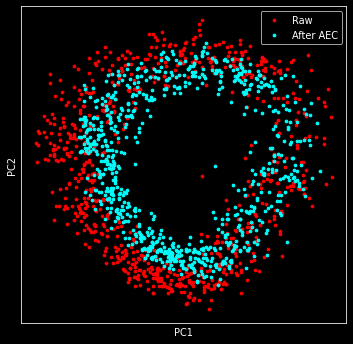

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(*X_test_PCA_raw.T, s=8, label="Raw", color="red")
plt.scatter(*X_test_PCA_aec.T, s=8, label="After AEC", color="cyan")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0, 0.5, 'PC2')

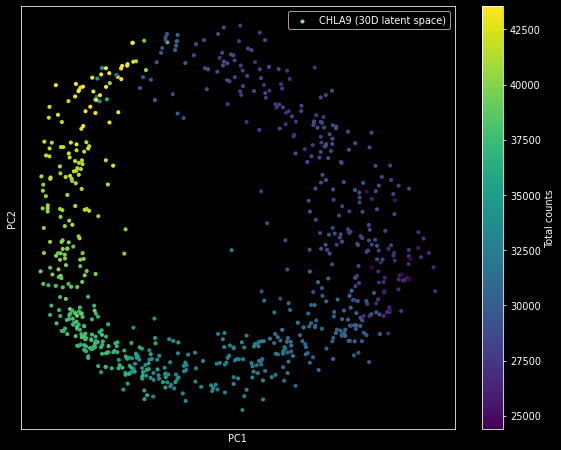

In [56]:
pca = PCA(n_components=2)
encoded_cells_PCA = pca.fit_transform(encoded_cells)

plt.figure(figsize=(10,8))
plt.scatter(*encoded_cells_PCA.T, s=10, label="CHLA9 (30D latent space)", c=y_test)
cbar = plt.colorbar()
cbar.set_label("Total counts")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.xlabel("PC1")
plt.ylabel("PC2")